# Credit Default Prediction
Defaulting occurs when a cardholder fails to make the required minimum payment on their credit card account within the specified time frame. This can lead to various consequences, such as fees, increased interest rates, negative impacts on credit scores, and potential legal actions by the credit card issuer to recover the debt.

Credit card defaults have risen by Rs 951 crore, to Rs 4,073 crore in FY23 from Rs 3,122 crore in FY22, according to data obtained from the Reserve Bank of India (RBI) under the Right to Information (RTI) Act. Although the retail segment played a critical role in the bank credit recovery process, the concentration of banks’ loan portfolios in unsecured lending can have serious macroeconomic and financial implications.

In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn import set_config
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score

## Contents
**1. Introduction**

**2. Data Ingestion**

**3. Exploratory Data Analysis**

**4. Feature Selection and Pre-processing**

**5. Feature Engineering**

**6. Model Building**

**7. Model Evaluation**

**8. Model Explainability**

**9. Conclusion**

## 1. Introduction 

Predicting Credit Card Default is a difficult problem to solve because of complex comsumer behavior, imbalance in dataset, macroeconomic conditions, model interpretability and regulatory constraints.

Machine learning models enhance the accuracy of predicting credit card defaults by leveraging large datasets and identifying complex patterns that might not be apparent through traditional statistical analysis. However, it's essential to continually update and refine these models with new data to maintain their accuracy and effectiveness in predicting credit card defaults.

In this project, I have used data from XYZ digital(mobile/phone based) bank to find credit card default. 

**Details of the data**
* customer ID
* label indicating training and oot data
* default target variable, where 1 indicates default and 0 no default
* Masked data with 50 unknown variables
* details of the mobile such as brand, carrier, device manufacturer, network etc. 

## 2. Data Ingestion

In [2]:
df = pd.read_csv('dataset - v2.csv')
pd.options.display.max_columns = 99
print('shape:',df.shape)
df.head()

shape: (6246, 62)


,decision_id,label,default,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50,brand,carrier,device_name,gms_version,manufacturer,network_type,screen_height,screen_width,screen_dpi
0,94dac214-e5d0-4758-b7ec-5a8e899b7f3e,modeling,0.0,0.0,41247.87,4526.83,0.0,73.0,15231.14,0.0,0.0,0.0,0.0,4583.33,1400.59,0.0,24.00,139.10,33.0,1.57,0.0,0.0,0.0,0.0,0.0,55121.00,800.0,0.0,0.0,0.76,531048.38,0.0,44448.88,0.23,1.04,0.0,0.0,0.0,0.0,6.0,158683.511600,8307.89,0.0,33006.40,0.0,1481.63,0.0,0.0,0.0,0.0,14467.50,0.0,0.0,OPPO,Jio 4G,OPPO CPH1931,21.02.14 (120406-352619232),OPPO,Unknown_0,1456.0,720.0,xhdpi
1,bcab40cd-4aaa-43d2-ae82-7d9ba2ded0a9,modeling,1.0,1.0,10278.99,35633.86,0.0,24.0,55549.52,0.0,0.0,0.0,0.0,1883.33,351.28,0.0,45381.52,2.00,6.0,1.26,0.0,0.0,0.0,0.0,0.0,23985.14,1860.0,0.0,0.0,0.82,83083.14,0.0,10521.63,0.12,1.14,0.0,0.0,0.0,0.0,0.0,2113.802462,28732.51,0.0,48840.27,0.0,401.55,0.0,0.0,0.0,0.0,465.60,0.0,0.0,OPPO,airtel,OPPO CPH1931,20.50.16 (120406-351607135),OPPO,Unknown_0,1456.0,720.0,xhdpi
2,c2f63ac4-e23c-40e7-8ef1-502c1d27df17,modeling,0.0,6.0,4603616.51,46242.48,0.0,354.0,542944.00,0.0,0.0,3.0,0.0,604414.36,30789.99,0.0,23708.39,50000.00,72.0,1.06,0.0,0.0,0.0,0.0,0.0,5634568.27,129495.0,0.0,0.0,NaN,5634568.27,0.0,4603616.51,9.32,0.97,0.0,0.0,0.0,48.0,59.0,776183.615900,276073.22,0.0,633661.62,0.0,153453.88,2.0,86567.0,0.0,0.0,41219.97,0.0,0.0,1cb6aef939f56e90,NaN,D8043bd139f034a8 1cb6aef93a8f1e32,20.36.15 (120400-333172415),d8043bd139f034a8,4G,1423.0,720.0,hdpi
3,dc8c2882-5868-470c-8669-9a7e87782a40,modeling,0.0,0.0,13656.98,15509.49,1.0,33.0,NaN,1.0,0.0,2.0,15000.0,935.67,491.30,0.0,NaN,24158.12,2.0,0.88,0.0,0.0,0.0,0.0,0.0,4043.00,0.0,1.0,0.0,0.20,90107.65,0.0,13075.83,0.18,0.44,0.0,0.0,0.0,0.0,0.0,8577.579649,NaN,0.0,22674.78,0.0,435.86,0.0,0.0,0.0,0.0,4057.50,0.0,0.0,YU,airtel,YU5530,20.45.16 (040408-344294571),YU,4G,1776.0,1080.0,xxhdpi
4,e40e990a-e89c-43c5-b933-f2b096aa1d35,modeling,1.0,7.0,3532898.80,16363.64,0.0,363.0,542944.00,0.0,0.0,3.0,15000.0,405174.44,34803.92,0.0,30000.00,48585.00,73.0,1.87,0.0,0.0,0.0,0.0,0.0,6369117.75,185732.0,1.0,0.0,NaN,6369117.75,0.0,3532898.80,13.96,0.97,0.0,0.0,0.0,62.0,62.0,21332.385090,296151.27,0.0,296151.27,0.0,253644.02,5.0,45058.5,0.0,0.0,40583.69,0.0,0.0,943a681d922e77b,NaN,638b5f4f86dfed5d 943a681d9bc971d,20.36.15 (100300-333172415),638b5f4f86dfed5d,Wifi,1920.0,1080.0,xhdpi


### modeling and oot data split: 75:25

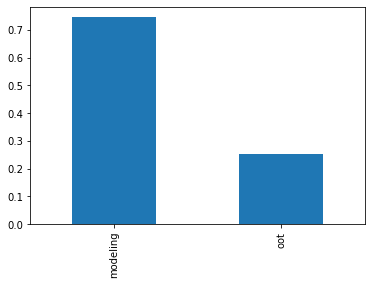

In [3]:
df['label'].value_counts(normalize=True).plot(kind = 'bar');

In [4]:
df_data = df[df['label'] == 'modeling']
df_data.shape

(4661, 62)

## 3.Exploratory Data Analysis

### Understanding Data Imbalance for Target Variable: Default

The occurrence of defaults is often much lower than non-default cases. Imbalanced datasets can affect model performance, as it might become skewed toward the majority class (non-default) and struggle to effectively learn patterns related to defaults.

* 0 : Default 77.5%

* 1 : No Default 22.5%

In [5]:
df_data['default'].value_counts()

0.0    3612
1.0    1049
Name: default, dtype: int64

### Summary: numerical variables

In [6]:
df_data.describe()

,default,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50,screen_height,screen_width
count,4661.000000,3724.000000,4.509000e+03,4.501000e+03,4444.000000,4509.000000,4.260000e+03,4444.000000,4397.000000,4444.000000,4.173000e+03,4509.000000,4508.000000,4444.000000,4.440000e+03,4.509000e+03,4509.000000,4438.000000,4173.000000,4173.000000,4509.000000,4173.000000,4509.000000,4.509000e+03,4.173000e+03,4173.000000,4509.000000,3168.000000,4.509000e+03,4444.000000,4.509000e+03,4509.000000,4432.000000,4009.000000,4173.000000,4173.000000,4509.000000,4509.000000,3.925000e+03,4.253000e+03,4509.00000,4.501000e+03,4173.000000,4.509000e+03,3724.000000,3724.000000,3975.000000,4509.000000,4.071000e+03,4021.000000,4173.000000,4429.000000,4429.000000
mean,0.225059,1.669173,2.909331e+05,2.212780e+04,0.143114,110.685740,1.377162e+05,0.252250,10.702524,1.606661,3.682758e+04,29505.525851,3944.227755,0.451395,8.919758e+03,2.950963e+04,12.211133,1.279126,0.085071,0.101126,0.004657,0.018212,0.011532,6.422409e+05,3.133523e+04,0.731608,0.030384,134.379107,7.930538e+05,0.059631,2.855259e+05,1.496769,11.668005,25.779995,0.073089,0.036904,3.468175,5.586161,7.101773e+04,1.002173e+05,0.04613,9.859835e+04,0.082914,1.349202e+04,0.547261,4861.377223,84.428050,0.016190,1.115641e+04,35.289659,0.025881,1775.886430,915.904493
std,0.417666,2.758058,9.781419e+05,7.684439e+04,0.527220,97.780384,9.326519e+05,0.535111,166.728136,2.189042,2.460079e+05,87195.053628,16072.299415,1.064698,4.310565e+04,6.937606e+04,18.355161,0.735059,0.279020,0.658182,0.087990,0.194985,0.159997,2.869873e+06,1.314517e+05,2.637376,0.191221,3223.536037,3.036961e+06,0.317257,9.574121e+05,2.552048,385.150349,235.063869,0.260314,0.286445,12.521009,15.764416,2.284996e+05,5.361089e+05,0.30683,3.449636e+05,0.463767,4.713678e+04,1.344769,17596.702471,1407.818208,0.133063,9.675970e+04,410.895820,0.238446,393.375076,193.117649
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,2.000000e+00,0.000000,-308.000000,0.000000,-1.000000e+05,0.000000,0.000000,0.000000,0.000000e+00,-6.612900e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-6.004179e+05,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.917522e+01,3.050000e+00,0.00000,1.900000e-01,0.000000,0.000000e+00,0.000000,-70569.500000,-221.000000,0.000000,1.000000e-01,0.000000,0.000000,720.000000,480.000000
25%,0.000000,0.000000,1.843551e+04,1.119820e+03,0.000000,40.000000,1.877210e+04,0.000000,0.000000,1.000000,0.000000e+00,803.330000,515.985000,0.000000,3.800000e+01,1.068000e+03,1.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,6.626853e+04,0.000000e+00,0.000000,0.000000,0.807500,1.114552e+05,0.000000,1.736879e+04,0.230000,0.930000,0.000000,0.000000,0.000000,0.000000,0.000000,1.688944e+03,1.146485e+04,0.00000,2.062468e+04,0.000000,6.342200e+02,0.000000,0.000000,0.000000,0.000000,2.051370e+03,0.000000,0.000000,1407.000000,720.000000
50%,0.000000,1.000000,5.235400e+04,5.608190e+03,0.000000,85.000000,4.131452e+04,0.000000,0.000000,1.000000,0.000000e+00,5282.930000,1254.560000,0.000000,4.229250e+02,7.425650e+03,5.000000,1.230000,0.000000,0.000000,0.000000,0.000000,0.000000,1.767246e+05,4.775000e+03,0.000000,0.000000,2.070000,2.648879e+05,0.000000,4.945639e+04,0.650000,1.020000,0.000000,0.000000,0.000000,0.000000,0.000000,4.873562e+03,2.634551e+04,0.00000,4.208334e+04,0.000000,1.811300e+03,0.000000,0.000000,0.000000,0.000000,4.455830e+03,0.000000,0.000000,1920.000000,1080.000000
75%,0.000000,2.000000,1.510065e+05,1.644696e+04,0.000000,153.000000,1.003947e+05,0.000000,0.000000,2.000000,5.500000e+03,16637.610000,2930.872500,1.000000,3.105602e+03,2.605900e+04,17.000000,1.800000,0.000000,0.000000,0.000000,0.000000,0.000000,4.369201e+05,2.330100e+04,1.000000,0.000000,6.982500,6.227707e+05,0.000

### Summary: Categorical Variable
* Some variables have too many categories. In feature engineering we will try to bin too many categories to 3-4 categories 

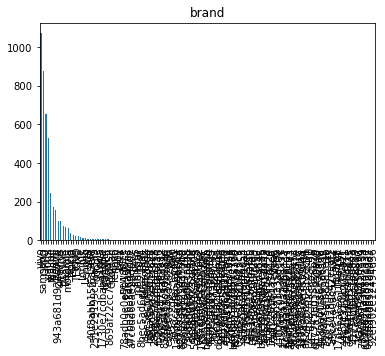

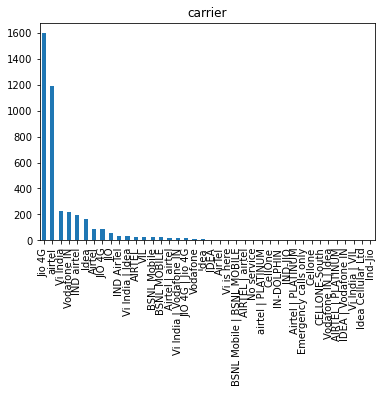

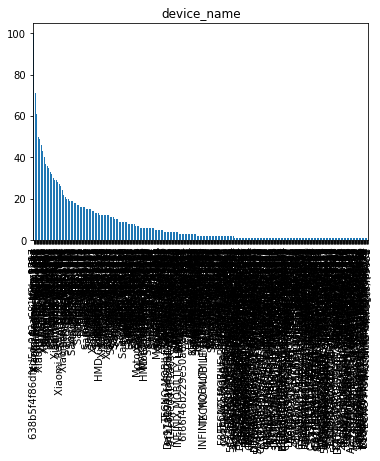

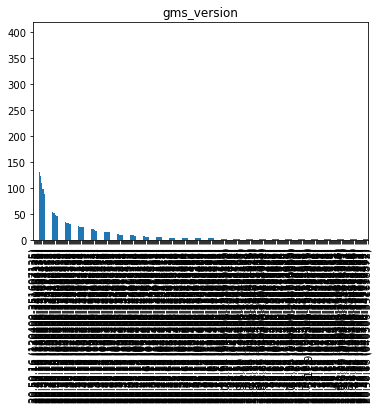

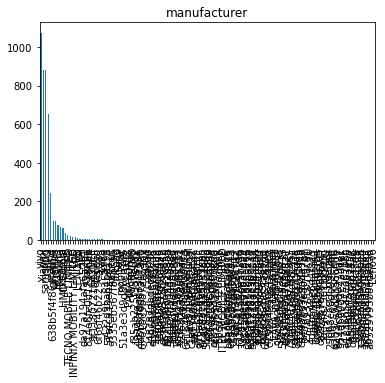

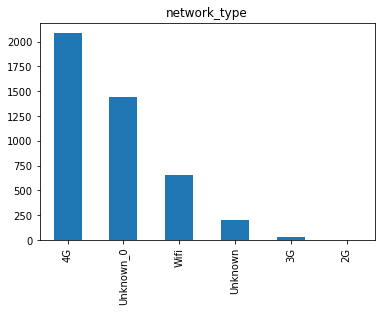

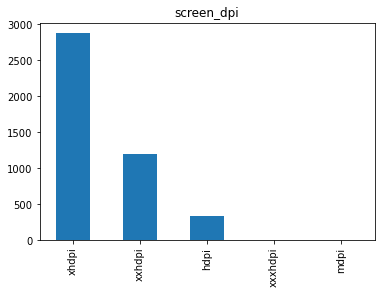

In [7]:
cat_cols = [cols for cols in df.columns if df_data[cols].dtypes == 'object' and cols not in ['decision_id','label']]
for cols in cat_cols:
    df_data[cols].value_counts().plot(kind = 'bar')
    plt.title(cols)
    plt.show()

### Cumulative max balance for defaulters v/s non-defaulters
* defaulters have higher balance in last 30 days
* based on SME knowledge v6:CUMULATIVE MAXIMUM BALANCE LAST 30 DAYS

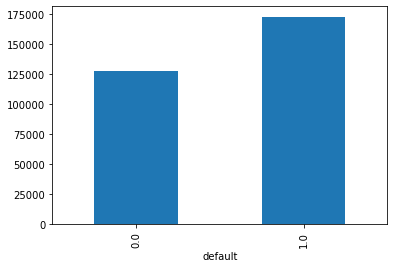

In [8]:
df_data.groupby('default')['v6'].mean().plot(kind = 'bar'); 

### Avg Monthly Credit and debit card transactions
* defaulters have high avg monthly credit and debit card transactions.
* based on SME knowledge v2: AVG. MONTHLY CREDIT TRANSACTIONS AMOUNT LAST 180 DAYS
* based on SME knowledge v11: AVG. MONTHLY DEBIT CARD TRANSACTIONS AMOUNT LAST 180 DAYS

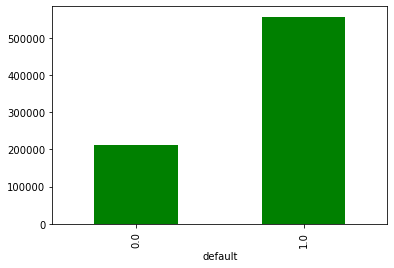

In [9]:
df_data.groupby('default')['v2'].mean().plot(kind = 'bar', color = 'green'); # credit card

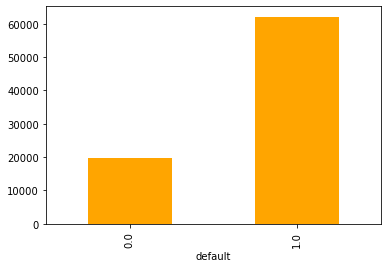

In [10]:
df_data.groupby('default')['v11'].mean().plot(kind = 'bar',color='orange'); #debit card

### NEFT/IMPS/RTGS transactions in last 30 days 
* defaulters have over all more transactions compared to non-defaulters 
* based on SME knowledge v36: # NEFT/RTGS/IMPS TRANSACTIONS LAST 30 DAYS

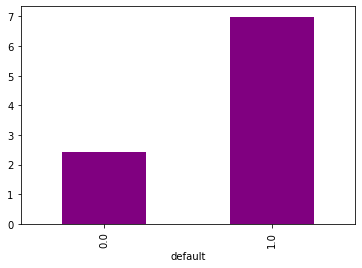

In [11]:
df_data.groupby('default')['v36'].mean().plot(kind = 'bar', color = 'purple');

## 4.Feature Selection and Pre-Processing

### Multicollinearity Analysis using Pearson Corelation
* dropping the colinear columns 

In [12]:
corr = df_data.corr()
corr_col = []
for i,row in enumerate(corr.columns):
    for j,col in enumerate(corr.index):
        if i>j:
            if corr.loc[row,col]>=0.90 or corr.loc[row,col]<=-0.90:
                print(row,col, corr.loc[row,col]) 
                print('{} pearson with label: {}'.format(row,pearsonr(df_data[row].fillna(df_data[row].mean()),df_data['default'])))
                print('{} pearson with label: {}'.format(col,pearsonr(df_data[col].fillna(df_data[col].mean()),df_data['default'])))
                corr_col.append((row,col))

v23 v12 0.9936239028154236
v23 pearson with label: (0.05522536826450335, 0.00016182280140003078)
v12 pearson with label: (0.04730951127441513, 0.001234292548420494)
v28 v12 0.9871335006918792
v28 pearson with label: (0.03931858938128269, 0.007260409506625149)
v12 pearson with label: (0.04730951127441513, 0.001234292548420494)
v28 v23 0.9728877909959445
v28 pearson with label: (0.03931858938128269, 0.007260409506625149)
v23 pearson with label: (0.05522536826450335, 0.00016182280140003078)
v30 v2 0.9947949211540167
v30 pearson with label: (0.15117835915805877, 3.118999209746645e-25)
v2 pearson with label: (0.14610812819678598, 1.1693658784903726e-23)
v34 v18 0.9208957580469829
v34 pearson with label: (-0.029035684070915186, 0.04745726370289598)
v18 pearson with label: (-0.030572718124191538, 0.03687242123549258)
v39 v6 0.9157336418590137
v39 pearson with label: (0.02899972800703036, 0.047732669355425285)
v6 pearson with label: (0.0196330422587026, 0.1801974863378827)
v42 v19 0.9517360899

In [13]:
corr_cols_drop = ['v12','v28','v2','v30','v18','v6','v19','v33','screen_width'] 

## 5.Feature Engineering
* replacing the categories with low number with 'others'
* For example: screen_dpi has mdpi and xxxhdpi categories having 5 obsevations totally, so replaced them with 'others'
* network_type had 2 categories as Unknown_0 and Unknown, which were put together as Unknown.
* manufaturers with values less than 100 were grouped together as others.
* carrier had many similar categories which were clubbed together.
* brand, device_name, gsm_version, decision_id and label were dropped 

In [14]:
cat_cols

['brand',
 'carrier',
 'device_name',
 'gms_version',
 'manufacturer',
 'network_type',
 'screen_dpi']

In [15]:
df_data['screen_dpi'].replace(dict.fromkeys(['mdpi','xxxhdpi'],'others'),inplace = True)
df_data['screen_dpi'].value_counts()

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


xhdpi     2878
xxhdpi    1203
hdpi       343
others       5
Name: screen_dpi, dtype: int64

In [16]:
df_data['network_type'].replace(to_replace = 'Unknown_0',value='Unknown',inplace = True)
df_data['network_type'].value_counts()

4G         2087
Unknown    1646
Wifi        659
3G           33
2G            4
Name: network_type, dtype: int64

In [17]:
for b in df_data['manufacturer'].unique():
    if df_data[df_data['manufacturer']==b]['decision_id'].count()<=100:
        df_data.loc[df_data['manufacturer']==b,'manufacturer'] = 'others'

df_data['manufacturer'].value_counts()

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


vivo       1074
Xiaomi      883
samsung     879
others      694
OPPO        654
realme      245
Name: manufacturer, dtype: int64

In [18]:
df_data['carrier'].replace(dict.fromkeys(['jio 4g', 'jio 4g | jio 4g','ind-jio',],'jio'),inplace = True)
df_data['carrier'].replace(dict.fromkeys(['ind airtel', 'airtel | airtel','airtel | platinum'],'airtel'),inplace = True)
df_data['carrier'].replace(dict.fromkeys(['!dea', 'idea','vodafone in','vil','vodafone', 
                                          'vi india | vodafone in','vi is here','vi india | idea', 
                                          'vodafone in | idea','idea cellular ltd', 'vi india | vil','vi india'],'vi'),inplace = True)

for b in df_data['carrier'].unique():
    if df_data[df_data['carrier']==b]['decision_id'].count()<=100:
        df_data.loc[df_data['carrier']==b,'carrier'] = 'others'

df_data['carrier'].value_counts()

Jio 4G         1599
airtel         1191
others          510
Vi India        230
Vodafone IN     218
IND airtel      194
Idea            164
Name: carrier, dtype: int64

In [19]:
cat_cols_drop = ['brand','device_name','gms_version','label','decision_id']
all_cols_drop = cat_cols_drop + corr_cols_drop 
df_model = df_data.drop(columns = all_cols_drop)
df_model.shape

(4661, 48)

### Creating modeling dataset 
* Finally, this data with 4661 rows and 49 variables will go into modeling
* categorical varibles: 5
* numerical variables: 43

In [20]:
X = df_model.drop(columns = 'default')
y = df_model['default']

In [21]:
cat_cols = [cols for cols in X.columns if X[cols].dtype == 'object']
print(len(cat_cols))
num_cols = [cols for cols in X.columns if cols not in cat_cols]
print(len(num_cols))

4
43


## 6.Model Building 

### Random Forest with hyperparameter tunning
Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions to make more accurate and robust classifications or predictions. It reduces overfitting by introducing randomness in the tree-building process and offers high flexibility and good performance for various types of data.

### Final Model Pipeline

In [22]:
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='mean'))])
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
preprocessor = ColumnTransformer([('num', num_transformer, num_cols),('cat', cat_transformer, cat_cols)])
pipeline = Pipeline([('preprocessor', preprocessor),('rf', RandomForestClassifier(class_weight='balanced',
                                                                                  random_state = 42))])

In [23]:
set_config(display="diagram")
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['v1', 'v3', 'v4', 'v5', 'v7',
                                                   'v8', 'v9', 'v10', 'v11',
                                                   'v13', 'v14', 'v15', 'v16',
                                                   'v17', 'v20', 'v21', 'v22',
                                                   'v23', 'v24', 'v25', 'v26',
                                                   'v27', 'v29', 'v31', 'v32',
                                                   'v34', 'v35', 'v36', 'v37',
                                                   'v38', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['carrier', 'manufacturer',
                                                   'network_type',
                                                   'screen_dpi'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

### Metric for scoring: 
For the imbalanced dataset, both positive and negative classes are distributed unequally. So we take help of Confusion Matrix to understand the actual and predicted class distribution and use the following metrics to evaluate our models. But when we use confusion matrix ther is always a thresholding component involved. Below are two threshold-free scoring techniques that helps us to evaluate model:

**AUPRC**
* The Area Under the Precision-Recall Curve (AUPRC) summarizes a binary classification model's precision-recall trade-off. It quantifies the model's ability to balance precision (positive predictive value) and recall (true positive rate) across different thresholds, particularly useful for imbalanced datasets where one class dominates the other.

**AUROC**
* The Area Under the Receiver Operating Characteristic (AUROC) curve measures the performance of a binary classification model across various thresholds. It illustrates the trade-off between sensitivity (true positive rate) and specificity (true negative rate), summarizing the model's ability to distinguish between classes, with a higher AUROC indicating better overall performance.


In [24]:
scores_roc = cross_validate(pipeline, X, y, cv=5, scoring='roc_auc',n_jobs = -1, return_train_score=True )
scores_pr = cross_validate(pipeline, X, y, cv=5, scoring='average_precision',n_jobs = -1, return_train_score=True )

pd.DataFrame({'Score':['AUROC','AUPRC'],
                      'Train':[np.mean(scores_roc['train_score']),np.mean(scores_pr['train_score'])],
                      'Test':[np.mean(scores_roc['test_score']),np.mean(scores_pr['test_score'])]})

,Score,Train,Test
0,AUROC,0.999519,0.711519
1,AUPRC,0.997432,0.453165


### Hyperparameter Tunning 

In [25]:
param_dist = {'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5,10,15],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['auto', 'sqrt', 'log2']}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, 
                                   scoring={'roc_auc','average_precision'}, refit='roc_auc',
                                   n_jobs=-1, cv=5, random_state=42,return_train_score=True)
random_search.fit(X, y)

pd.DataFrame({'test_AUPRC':random_search.cv_results_['mean_test_average_precision'],
              'train_AUPRC':random_search.cv_results_['mean_train_average_precision'],
             'test_AUROC':random_search.cv_results_['mean_test_roc_auc'],
              'train_AUROC':random_search.cv_results_['mean_train_roc_auc']})

,test_AUPRC,train_AUPRC,test_AUROC,train_AUROC
0,0.458085,0.569835,0.717720,0.818423
1,0.460027,0.570463,0.717389,0.821138
2,0.481907,0.783291,0.733558,0.944998
3,0.476605,0.877360,0.731076,0.973185
4,0.479620,0.858438,0.733238,0.968319
5,0.473227,0.932468,0.727678,0.985988
6,0.486609,0.857720,0.738948,0.968420
7,0.470850,0.775993,0.722604,0.941876
8,0.461397,0.571862,0.716712,0.820800
9,0.479590,0.820805,0.730372,0.956228


### Based on the mean train and mean test scores, I have taken the row 2, since it has minimal overfitting.

|Score|	Train|	Test|
|-----|-----|------|
|AUROC|	0.82|	0.72|
|AUPRC|	0.57|	0.46|


In [26]:
# final model hyperparameter
random_search.cv_results_['params'][1]

{'rf__n_estimators': 50,
 'rf__min_samples_split': 10,
 'rf__min_samples_leaf': 1,
 'rf__max_features': 'auto',
 'rf__max_depth': 5}

In [27]:
pipeline = Pipeline([('preprocessor', preprocessor),
                     ('rf', RandomForestClassifier(class_weight='balanced',n_estimators= 50, 
                                                   min_samples_split= 10, min_samples_leaf=1, 
                                                   max_features='auto', max_depth= 5,
                                                   random_state = 42))])

scores_roc = cross_validate(pipeline, X, y, cv=5, scoring='roc_auc',n_jobs = -1, return_train_score=True )
scores_pr = cross_validate(pipeline, X, y, cv=5, scoring='average_precision',n_jobs = -1, return_train_score=True )

pd.DataFrame({'Score':['AUROC','AUPRC'],
                      'Train':[np.mean(scores_roc['train_score']),np.mean(scores_pr['train_score'])],
                      'Test':[np.mean(scores_roc['test_score']),np.mean(scores_pr['test_score'])]})

,Score,Train,Test
0,AUROC,0.821138,0.717389
1,AUPRC,0.570463,0.460027


### XGBoost with hyperparameter Tunning
XGBoost (Extreme Gradient Boosting) is a powerful ensemble learning technique that sequentially builds a series of decision trees, each correcting errors made by the previous ones. It optimizes a specific objective function while preventing overfitting through regularization techniques, providing high prediction accuracy and speed for both regression and classification tasks.

In [28]:
pipeline = Pipeline([('preprocessor', preprocessor),('xgb', xgb.XGBClassifier(objective='binary:logistic',
                                                                            use_label_encoder=False,
                                                                            eval_metric = roc_auc_score))])
scores_roc = cross_validate(pipeline, X, y, cv=5, scoring='roc_auc',n_jobs = -1, return_train_score=True )
scores_pr = cross_validate(pipeline, X, y, cv=5, scoring='average_precision',n_jobs = -1, return_train_score=True )

pd.DataFrame({'Score':['AUROC','AUPRC'],
                      'Train':[np.mean(scores_roc['train_score']),np.mean(scores_pr['train_score'])],
                      'Test':[np.mean(scores_roc['test_score']),np.mean(scores_pr['test_score'])]})

,Score,Train,Test
0,AUROC,0.998756,0.692321
1,AUPRC,0.995338,0.429840


In [29]:
param_dist = {'xgb__n_estimators': [50,100,200],
    'xgb__max_depth': [None,3,5,7],
    'xgb__learning_rate': [0.001,0.01,0.1],
    'xgb__subsample': [0.1,0.5,0.9],
    'xgb__colsample_bytree': [0.1,0.5,0.9]}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, 
                                   scoring={'roc_auc','average_precision'}, refit='roc_auc',
                                   n_jobs=-1, cv=5, random_state=42,return_train_score=True)
random_search.fit(X, y)

pd.DataFrame({'test_AUPRC':random_search.cv_results_['mean_test_average_precision'],
              'train_AUPRC':random_search.cv_results_['mean_train_average_precision'],
             'test_AUROC':random_search.cv_results_['mean_test_roc_auc'],
              'train_AUROC':random_search.cv_results_['mean_train_roc_auc']})

[15:44:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,test_AUPRC,train_AUPRC,test_AUROC,train_AUROC
0,0.443852,0.510564,0.705378,0.761508
1,0.442617,0.507189,0.702159,0.759830
2,0.464946,0.700242,0.721689,0.871825
3,0.421443,0.445497,0.681249,0.709654
4,0.456564,0.591725,0.706857,0.822378
5,0.438391,0.497200,0.696844,0.750738
6,0.447026,0.520397,0.703933,0.767689
7,0.466770,0.738711,0.719903,0.905884
8,0.437177,0.508878,0.697487,0.748452
9,0.446312,0.520188,0.703693,0.772429


### Based on the mean train and mean test scores, I have taken the row 9, since it has minimal overfitting
|Score|	Train|	Test|
|-----|-----|------|
|AUROC|	0.74|	0.70|
|AUPRC|	0.50|	0.44|


In [30]:
random_search.cv_results_['params'][8]

{'xgb__subsample': 0.9,
 'xgb__n_estimators': 100,
 'xgb__max_depth': 3,
 'xgb__learning_rate': 0.01,
 'xgb__colsample_bytree': 0.9}

In [31]:
pipeline = Pipeline([('preprocessor', preprocessor),('xgb', xgb.XGBClassifier(objective='binary:logistic',
                                                                            use_label_encoder=False,
                                                                            eval_metric = roc_auc_score,
                                                                             n_estimators = 100,
                                                                             max_depth = 3,
                                                                             subsample = 0.9,
                                                                             learning_rate = 0.01,
                                                                             colsample_bytree = 0.9))])
scores_roc = cross_validate(pipeline, X, y, cv=5, scoring='roc_auc',n_jobs = -1, return_train_score=True )
scores_pr = cross_validate(pipeline, X, y, cv=5, scoring='average_precision',n_jobs = -1, return_train_score=True )

pd.DataFrame({'Score':['AUROC','AUPRC'],
                      'Train':[np.mean(scores_roc['train_score']),np.mean(scores_pr['train_score'])],
                      'Test':[np.mean(scores_roc['test_score']),np.mean(scores_pr['test_score'])]})

,Score,Train,Test
0,AUROC,0.748452,0.697487
1,AUPRC,0.508878,0.437177


## 7.Model Evaluation
**XGBoost v/s Random Forest**

|Score|	Train_RF|	Test_RF|Train_XGB| Test_XGB|        
| -----| ----| ----|----|----|
|	AUROC|	0.82|	0.72|0.75|0.70|
|	AUPRC|	0.57|	0.46|0.50|0.44|

* The scores shows, XGB has lower overfitting and the algorithm is able to generalize the non-linear pattern in the data for classification.

### Thresholding 
* The metrics we have defined earlier AUROC and AUPRC are threshold-free evaluation metrics. But in order to find precision and recall, we require a definite threshold.
* Threshold can be undestood easily with comfusion matrix. So we start with confusion matrix, and understand how can we find best threshold for the imbalanced dataset. 

In [32]:
y_pred = cross_val_predict(pipeline, X, y, cv=5, method='predict_proba')

[15:44:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

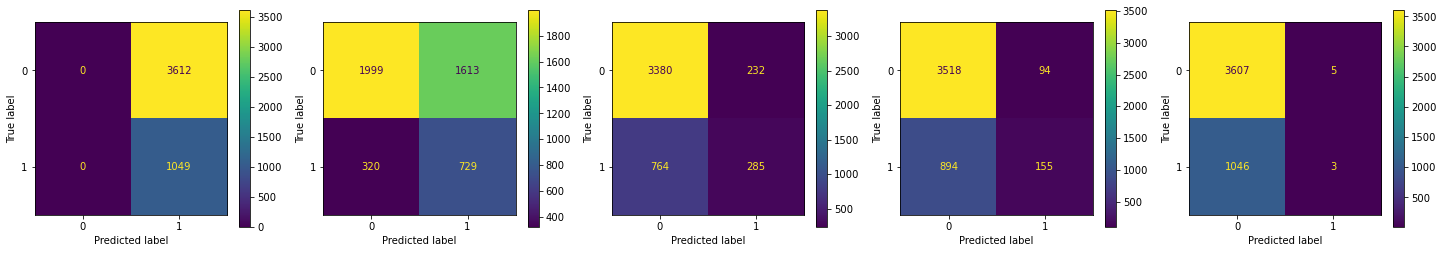

In [33]:
threshold = [0.25,0.3,0.4,0.5,0.65]
fig, axes = plt.subplots(nrows=1, ncols=len(threshold), figsize=(25, 4), squeeze=True)
for i in range(len(threshold)):
    y_pred_th = (y_pred[:,1]>threshold[i]).astype('float')
    conf_mat = confusion_matrix(y, y_pred_th)
    ConfusionMatrixDisplay(conf_mat).plot(ax = axes[i])

* The confusion metrics above shows us any threshold above 0.65 has almost no true positives, i.e. model is unable to identify any true defaults. The same goes for any threshold below 0.25, i.e. model is unable to indentify non-defaults. 
* for threshold 0.3, majority of default cases are classified correctly. Using this threshold we might have to compromise on false positives but for this case flagging non-defaulters are deafulters is better than leaving out any defaulters. Lets try to fine tune in next iteration.

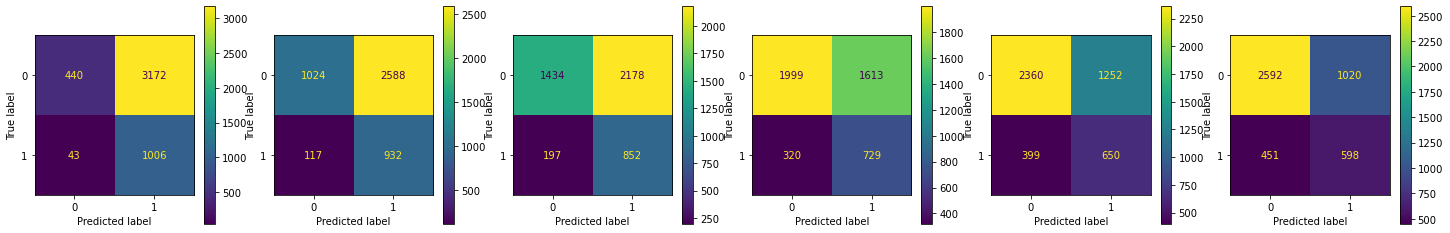

In [34]:
threshold = [0.27,0.28,0.29,0.3,0.31,0.32]
fig, axes = plt.subplots(nrows=1, ncols=len(threshold), figsize=(25, 4), squeeze=True)
for i in range(len(threshold)):
    y_pred_th = (y_pred[:,1]>threshold[i]).astype('float')
    conf_mat = confusion_matrix(y, y_pred_th)
    ConfusionMatrixDisplay(conf_mat).plot(ax = axes[i])

* Based on fine tunning, 0.29 looks like a good threshold, in order to catch all defaulters. We compromise on false positives, but essentially we can't let go any defaulter. 

## 8.Model Explainability
In my experience, explaining model to the stakeholders have been an important part of modelling. Including a few things to explain model in a better way.

### a. Final results

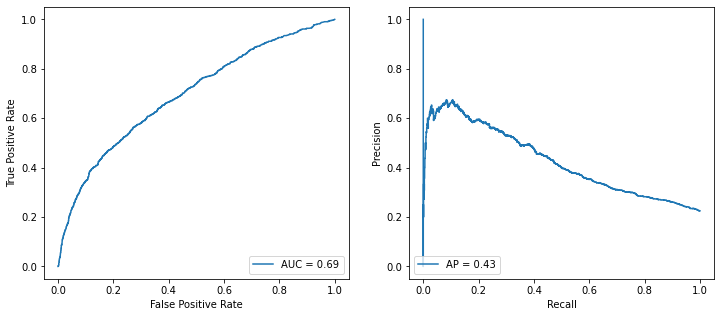

In [35]:
from sklearn import metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fpr, tpr, _ = roc_curve(y, y_pred[:,1])
roc_auc = metrics.auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

prec, recall, _ = precision_recall_curve(y, y_pred[:,1])
average_precision = metrics.average_precision_score(y, y_pred[:,1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, average_precision=average_precision)

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

### b.Feature Importance

In the context of machine learning, feature importance in a model like refers to quantifying the influence or contribution of each input feature to the model's predictions. It identifies which features have more impact on the model's output, aiding in understanding which aspects of the input data are crucial for accurate predictions or classifications. This helps prioritize or interpret features based on their relevance in the model's decision-making process.

In [36]:
pipeline.fit(X,y);
pd.DataFrame({'columns':X.columns, 
              'importance':pipeline[-1].feature_importances_}).sort_values('importance',
                                                            ascending = False).reset_index(drop=True)[:10]

[15:44:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,columns,importance
0,v11,0.106913
1,v39,0.104200
2,v38,0.069042
3,v32,0.051788
4,v44,0.048362
5,v45,0.045542
6,screen_height,0.045490
7,v27,0.040319
8,v49,0.039854
9,v1,0.037697


### c.PDP Plots
Partial dependence plots illustrate the relationship between a specific feature and the predicted outcome of a machine learning model while marginalizing the impact of all other features. They show how the target variable changes as the selected feature varies, holding other features at fixed values (often their average or median). These plots help understand the individual impact of a feature on predictions, revealing potential non-linear or interaction effects between the feature and the model's output.

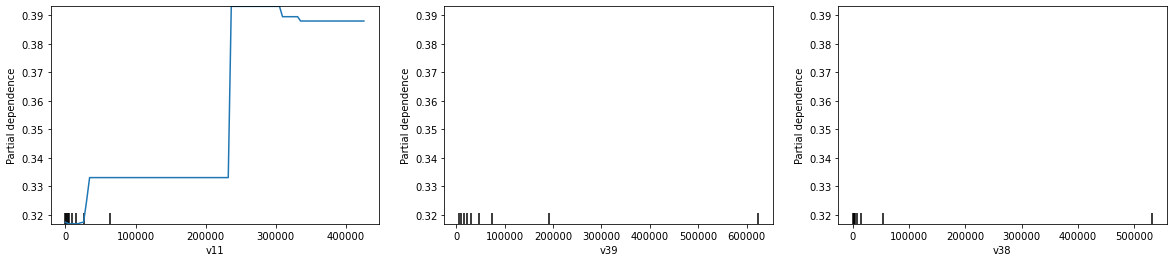

In [37]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4), squeeze=True)
features = ['v11','v39','v38']
plot_partial_dependence(pipeline, X, features,n_jobs=-1, ax = axes);

### d.Final Predictions 

In [38]:
df_oot = df[df['label'] == 'oot']
print(df_oot.shape)
df_oot.head()

(1585, 62)


,decision_id,label,default,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50,brand,carrier,device_name,gms_version,manufacturer,network_type,screen_height,screen_width,screen_dpi
4661,7a74c817-f036-4214-ade0-e5bfa07fd0fc,oot,NaN,0.0,514936.31,1450.40,0.0,59.0,150981.97,0.0,0.0,3.0,720000.0,7235.29,1841.30,0.0,663.47,1289.94,4.0,1.13,0.0,0.0,0.0,0.0,0.0,338799.64,3420.0,2.0,0.0,NaN,338799.64,0.0,514936.31,1.74,0.58,0.0,0.0,0.0,0.0,0.0,2187.731685,150981.97,0.0,275066.49,0.0,17164.54,0.0,0.00,0.0,0.0,5851.41,0.0,0.0,xiaomi,IND airtel,Xiaomi Redmi 6A,20.50.16 (100306-351607135),Xiaomi,4G,1344.0,720.0,xhdpi
4662,7ba155b6-ce2c-432e-a717-163acd6306da,oot,NaN,0.0,445.33,4488.08,0.0,18.0,NaN,0.0,0.0,0.0,330000.0,7497.47,205.60,0.0,49.06,2049.00,14.0,0.05,0.0,0.0,0.0,0.0,0.0,23057.12,2.0,2.0,0.0,0.02,37830.12,0.0,445.33,0.16,11.02,0.0,0.0,0.0,0.0,0.0,3268.164707,NaN,0.0,12314.03,0.0,18.86,0.0,0.00,0.0,0.0,NaN,0.0,0.0,Xiaomi,Vi India,Xiaomi Redmi 8A,20.39.15 (100306-335085812),Xiaomi,4G,1364.0,720.0,xhdpi
4663,831a2f46-dbb4-47a9-9f3b-91ff7d0214d2,oot,NaN,2.0,10247.17,4.43,0.0,24.0,17664.16,0.0,0.0,4.0,0.0,0.00,332.73,1.0,22.60,16532.00,0.0,0.79,0.0,0.0,0.0,0.0,0.0,61222.70,21.0,0.0,0.0,NaN,61222.70,0.0,6052.67,0.08,1.00,NaN,0.0,0.0,0.0,0.0,9744.252670,9813.42,0.0,4675.93,0.0,201.76,0.0,127.62,0.0,0.0,2360.83,NaN,0.0,samsung,airtel,Samsung SM-A307FN,20.47.14 (120400-349456378),samsung,Unknown_0,1423.0,720.0,hdpi
4664,d4ec4849-b80e-49e9-a8a5-0e17f7d96c02,oot,NaN,NaN,91163.98,2498.04,0.0,119.0,10992.66,1.0,NaN,6.0,0.0,2400.00,1722.19,1.0,52.00,52.00,9.0,0.18,0.0,0.0,0.0,0.0,0.0,310331.32,0.0,0.0,0.0,1.55,316883.32,0.0,91163.98,1.19,1.02,938.0,0.0,0.0,0.0,0.0,2341.134052,10992.66,0.0,41408.34,0.0,3038.80,NaN,NaN,816.0,0.0,2115.11,938.0,0.0,samsung,Airtel,Samsung SM-J200G,20.50.16 (020304-351607135),samsung,3G,960.0,540.0,hdpi
4665,e67c5ff3-3751-40d4-b621-4987df98ce1b,oot,NaN,0.0,39606.80,6254.56,0.0,138.0,62969.22,1.0,0.0,0.0,0.0,2790.00,1286.86,0.0,5257.71,17566.01,14.0,1.80,0.0,0.0,0.0,0.0,0.0,124245.74,0.0,0.0,0.0,2.50,259738.73,0.0,37181.19,0.62,0.93,0.0,0.0,0.0,0.0,1.0,5208.136484,32018.25,0.0,36255.53,0.0,1239.37,0.0,0.00,0.0,0.0,11106.14,0.0,0.0,HUAWEI,airtel,HUAWEI RIO-L01,20.47.14 (040408-349456378),HUAWEI,4G,1776.0,1080.0,xxhdpi


In [39]:
X_test = df_oot.drop(columns = all_cols_drop+['default'])
y_pred = pipeline.predict_proba(X_test)[:,1]

In [40]:
pd.options.display.max_rows=9999
df_submission = pd.DataFrame({'decision_id':df_oot['decision_id'],'prediction':y_pred})
df_submission.to_csv('submission.csv')
df_submission

,decision_id,prediction
4661,7a74c817-f036-4214-ade0-e5bfa07fd0fc,0.318014
4662,7ba155b6-ce2c-432e-a717-163acd6306da,0.293481
4663,831a2f46-dbb4-47a9-9f3b-91ff7d0214d2,0.308817
4664,d4ec4849-b80e-49e9-a8a5-0e17f7d96c02,0.293260
4665,e67c5ff3-3751-40d4-b621-4987df98ce1b,0.284203
4666,ec51d141-20b2-4509-92ac-78343d7fc9cf,0.302090
4667,0991fec2-bc6f-4ebc-a80d-0a229f4e01cd,0.268431
4668,0a54f013-9847-4c3c-8e9b-9b8722ca0beb,0.335524
4669,6bf596a0-e94e-4274-8b5d-216d0a54a877,0.299923
4670,7db3edf4-dd14-4eaa-aaf9-78e4f919f73c,0.302220


## 9.Conclusion
* The notebook takes you through the entire Modelling pipeline for credit card default prediction. It shows how can we solve imbalanced dataset problem. 
* We start from data ingestion and pre-processing, and then use model pipeline for separate treatment of categorical and numerical features. 
* Model evaluation using threshold-free metrics like AUROC and AUPRC showed XGB was a better model. And using confusion matrix we estimated the threshold for the predictions. 
* Finally, we interprested the model using top features and PDP plots. 
* Few things that can be added to the model:
    * balancing the dataset using some sampling technique.
    * feature selection by recursively eliminating features and check if the evaluation metrics drops. 
    * Using Shapley plots for better model interpretability. 